In [15]:
# ============================
# Imports & Config
# ============================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import os
from tqdm import tqdm

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Running on GPU:", torch.cuda.get_device_name(0))


PyTorch version: 2.5.1+cu121
CUDA available: True
Running on GPU: NVIDIA RTX A6000


# Load KDD2020 NYC Taxi Dataset

The dataset contains:
- `flow`: main input tensor of size (T, 16, 12, 2)
- `trans`: dynamic origin-destination (OD) transition matrices
- `ex_knlg`: external features (weather, hour, weekday, event features)

This section loads the train/val/test `.npz` files and prints their structure.

In [16]:
# ============================
# Load KDD2020 NYC Taxi Dataset
# ============================

data_root = "/home/nuoxu9/traffic_flow_prediction/data/KDD2020/NYCTaxi"

train_path = os.path.join(data_root, "taxi_train.npz")
val_path   = os.path.join(data_root, "taxi_val.npz")
test_path  = os.path.join(data_root, "taxi_test.npz")

train_npz = np.load(train_path)
val_npz   = np.load(val_path)
test_npz  = np.load(test_path)

print("Train keys:", train_npz.files)
print("Val keys:", val_npz.files)
print("Test keys:", test_npz.files)

flow_train = train_npz["flow"]      # (T, 16, 12, 2)
trans_train = train_npz["trans"]    # (T, 16, 12, 16, 12, 2)
ex_train = train_npz["ex_knlg"]     # (T, 65)

flow_val = val_npz["flow"]
flow_test = test_npz["flow"]

print("Flow train shape:", flow_train.shape)
print("Trans train shape:", trans_train.shape)
print("Exogenous shape:", ex_train.shape)


Train keys: ['flow', 'trans', 'ex_knlg']
Val keys: ['flow', 'trans', 'ex_knlg']
Test keys: ['flow', 'trans', 'ex_knlg']
Flow train shape: (1920, 16, 12, 2)
Trans train shape: (1920, 16, 12, 16, 12, 2)
Exogenous shape: (1920, 65)


# Visualize the Data

Before training, we visualize:

1. A heatmap of inflow/outflow for a specific timestep.
2. Time series at a selected grid cell.

This helps us confirm that:
- The dataset loaded correctly.
- Patterns look realistic.
- The grid structure is meaningful.


Sample inflow shape: (16, 12)
Sample outflow shape: (16, 12)


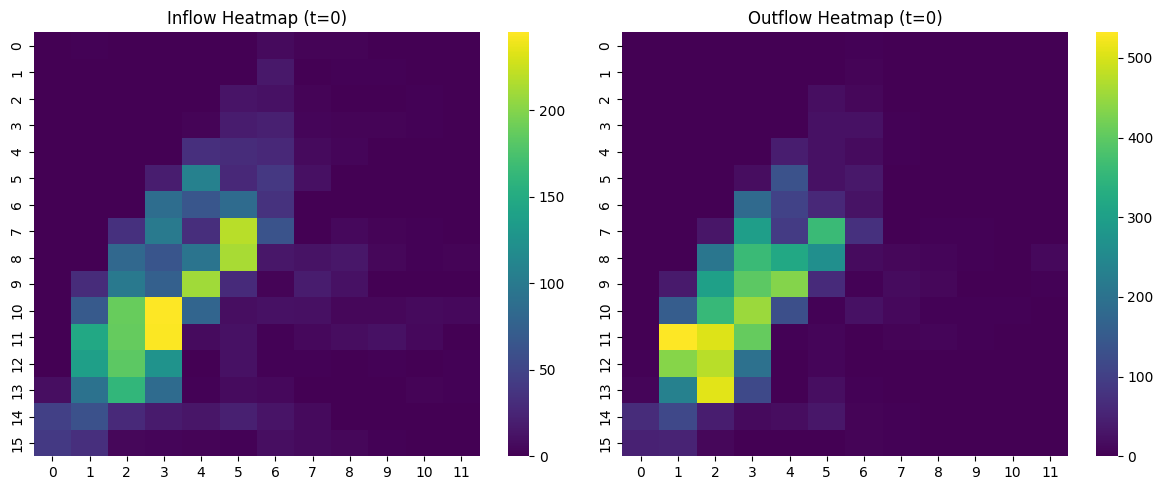

In [17]:
# ============================
# Inspect & Visualize Dataset
# ============================

# Choose a timestep to inspect
t = 0

sample_flow = flow_train[t]   # shape: (16, 12, 2)
inflow  = sample_flow[:, :, 0]
outflow = sample_flow[:, :, 1]

print("Sample inflow shape:", inflow.shape)
print("Sample outflow shape:", outflow.shape)

# Plot inflow & outflow side by side
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Inflow Heatmap (t=0)")
sns.heatmap(inflow, cmap='viridis')

plt.subplot(1, 2, 2)
plt.title("Outflow Heatmap (t=0)")
sns.heatmap(outflow, cmap='viridis')

plt.tight_layout()
plt.show()


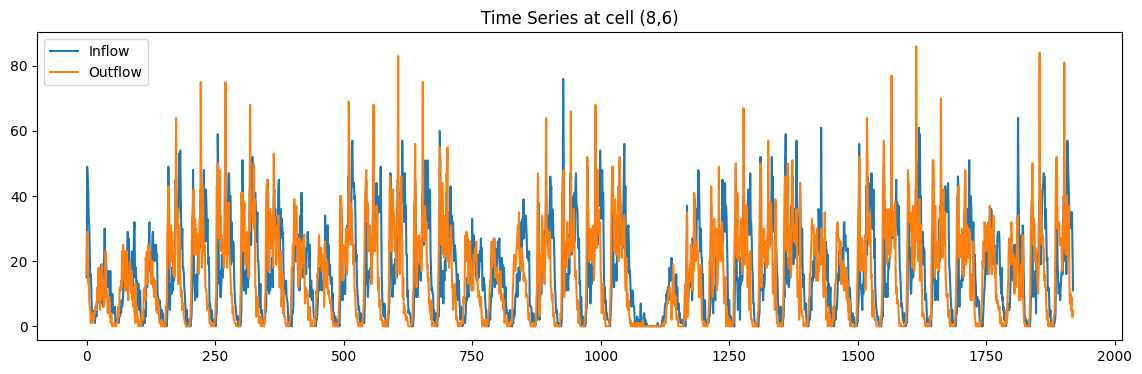

In [18]:
i, j = 8, 6

ts_in = flow_train[:, i, j, 0]
ts_out = flow_train[:, i, j, 1]

plt.figure(figsize=(14, 4))
plt.plot(ts_in, label="Inflow")
plt.plot(ts_out, label="Outflow")
plt.legend()
plt.title(f"Time Series at cell ({i},{j})")
plt.show()


### Interpretation

- The **heatmaps** should show spatial distributions of traffic inflow/outflow.
- The **time series** should show daily & weekly periodic patterns typical of traffic data.

If the plots look smooth and structured, the dataset is correct and ready for modeling.


# Normalization & Sliding Window Creation

Traffic flow values vary significantly by location and time.  
Neural networks train much more effectively when inputs are normalized.

Here we will:

1. Compute the mean and standard deviation using the **training set only**  
2. Normalize train/val/test  
3. Convert time series into supervised learning samples using a sliding window  
   - **Input length = 12 timesteps**  
   - **Output length = 3 timesteps**

This produces tensors of shape:

- `X`: (num_samples, 12, 16, 12, 2)
- `Y`: (num_samples, 3, 16, 12, 2)


In [19]:
# ============================
# Normalization
# ============================

# Compute mean & std using *only* training data
flow_mean = flow_train.mean(axis=(0, 1, 2))
flow_std  = flow_train.std(axis=(0, 1, 2)) + 1e-6  # avoid division by zero

print("Flow mean:", flow_mean)
print("Flow std:", flow_std)

def normalize(x):
    return (x - flow_mean) / flow_std

def denormalize(x):
    return x * flow_std + flow_mean

# Normalize datasets
flow_train_norm = normalize(flow_train)
flow_val_norm   = normalize(flow_val)
flow_test_norm  = normalize(flow_test)


Flow mean: [32.01392415 32.01924099]
Flow std: [89.42449993 97.83843562]


### Sliding Window Construction

We transform the continuous time series into (X, Y) pairs where:

- `X[t] = flow[t : t+12]`
- `Y[t] = flow[t+12 : t+15]`

This gives:
- multiple training samples
- consistent window lengths
- fixed temporal receptive fields for models


In [20]:
def create_dataset(flow_data, input_len=12, output_len=3):
    X, Y = [], []
    T = flow_data.shape[0]

    for t in range(T - input_len - output_len):
        X.append(flow_data[t : t + input_len])            # [12, 16, 12, 2]
        Y.append(flow_data[t + input_len : t + input_len + output_len])  # [3, 16, 12, 2]

    return np.array(X), np.array(Y)


X_train, Y_train = create_dataset(flow_train_norm)
X_val,   Y_val   = create_dataset(flow_val_norm)
X_test,  Y_test  = create_dataset(flow_test_norm)

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)


X_train: (1905, 12, 16, 12, 2)
Y_train: (1905, 3, 16, 12, 2)


### Build PyTorch Dataset & DataLoader

We now convert numpy arrays into PyTorch tensors and create DataLoaders for:
- training
- validation
- testing

This allows batching and shuffling during model training.


In [21]:
class TrafficDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


batch_size = 32

train_loader = DataLoader(TrafficDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TrafficDataset(X_val,   Y_val),   batch_size=batch_size)
test_loader  = DataLoader(TrafficDataset(X_test,  Y_test),  batch_size=batch_size)

print("Train batches:", len(train_loader))


Train batches: 60


# 🧩 STGCN Implementation

STGCN uses:
- Temporal Conv (TCN)
- Graph Conv (GCN)
- Stacked ST-blocks

Before defining the model, we construct the grid adjacency matrix for the 16×12 map.
Each grid cell connects to its 4 neighbors (up, down, left, right).


In [22]:
# ============================
# Build Adjacency Matrix for 16x12 Grid
# ============================

H, W = 16, 12
N = H * W

def build_grid_adj(H, W):
    A = np.zeros((H * W, H * W))
    
    def node_id(i, j):
        return i * W + j

    for i in range(H):
        for j in range(W):
            idx = node_id(i, j)

            # connect up
            if i > 0:
                A[idx, node_id(i-1, j)] = 1
            # connect down
            if i < H - 1:
                A[idx, node_id(i+1, j)] = 1
            # connect left
            if j > 0:
                A[idx, node_id(i, j-1)] = 1
            # connect right
            if j < W - 1:
                A[idx, node_id(i, j+1)] = 1

    return A

A = build_grid_adj(H, W)

print("Adjacency shape:", A.shape)
print("Non-zero connections:", (A>0).sum())

# ============================
# Normalize adjacency matrix
# ============================

A_torch = torch.tensor(A, dtype=torch.float32)

I = torch.eye(N)
A_hat = A_torch + I

# D^{-1/2}
D = torch.diag(torch.pow(A_hat.sum(1), -0.5))
A_norm = D @ A_hat @ D

A_norm = A_norm.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

print("A_norm ready:", A_norm.shape)


Adjacency shape: (192, 192)
Non-zero connections: 712
A_norm ready: torch.Size([192, 192])


# Training Loop for STGCN

This section defines the training and validation loops for STGCN.  
We use:

- **MSE loss** for regression  
- **Adam optimizer**  
- **Mini-batch training**  
- **Validation after each epoch**  
- **Best-model saving**

This will let us monitor model performance and prevent overfitting.


In [23]:
# ============================
# Training Loop
# ============================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0

    for X, Y in loader:
        X = X.to(device)   # (B, 12, 16, 12, 2)
        Y = Y.to(device)   # (B,  3, 16, 12, 2)

        optimizer.zero_grad()
        preds = model(X, A_norm)       # (B, 3, 16, 12, 2)

        loss = criterion(preds, Y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)


def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for X, Y in loader:
            X = X.to(device)
            Y = Y.to(device)

            preds = model(X, A_norm)
            loss = criterion(preds, Y)
            total_loss += loss.item()

    return total_loss / len(loader)

# ============================
# Train STGCN
# ============================

model = STGCN(in_channels=2, hidden=32, output_steps=3).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
best_val_loss = float('inf')

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "stgcn_best.pth")
        print("  -> Saved new best model")

print("Training complete!")


Epoch 1/20 | Train Loss: 0.501723 | Val Loss: 0.288261
  -> Saved new best model
Epoch 2/20 | Train Loss: 0.233696 | Val Loss: 0.247387
  -> Saved new best model
Epoch 3/20 | Train Loss: 0.201553 | Val Loss: 0.220372
  -> Saved new best model
Epoch 4/20 | Train Loss: 0.183854 | Val Loss: 0.206465
  -> Saved new best model
Epoch 5/20 | Train Loss: 0.178587 | Val Loss: 0.198585
  -> Saved new best model
Epoch 6/20 | Train Loss: 0.166354 | Val Loss: 0.186636
  -> Saved new best model
Epoch 7/20 | Train Loss: 0.157170 | Val Loss: 0.178489
  -> Saved new best model
Epoch 8/20 | Train Loss: 0.150261 | Val Loss: 0.175654
  -> Saved new best model
Epoch 9/20 | Train Loss: 0.147795 | Val Loss: 0.165193
  -> Saved new best model
Epoch 10/20 | Train Loss: 0.142803 | Val Loss: 0.161611
  -> Saved new best model
Epoch 11/20 | Train Loss: 0.140512 | Val Loss: 0.161752
Epoch 12/20 | Train Loss: 0.134826 | Val Loss: 0.154946
  -> Saved new best model
Epoch 13/20 | Train Loss: 0.133722 | Val Loss: 0.15

### Training & Validation Loss Over Epochs
This plot helps us diagnose overfitting or underfitting.


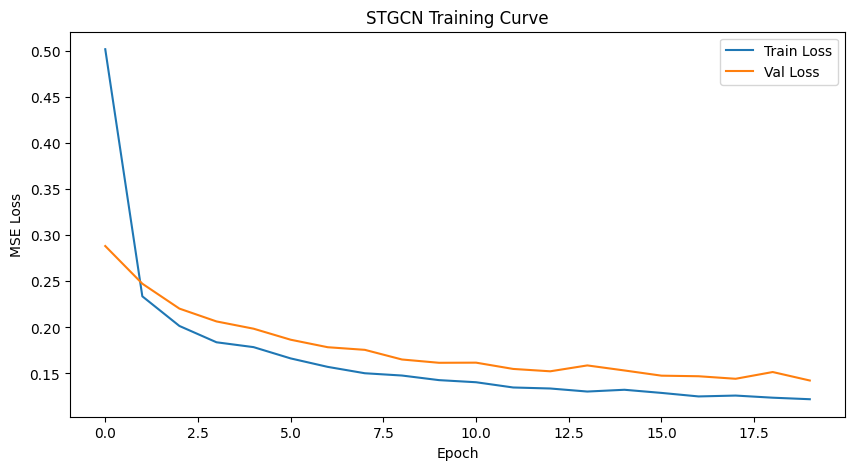

In [24]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("STGCN Training Curve")
plt.show()
